In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from helpers.processor import process_dir_to_chunks

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input
from keras.utils import to_categorical

2025-08-03 06:25:22.134740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dir_path = '../selectedcomposers'

df = process_dir_to_chunks(dir_path, 200)

print(df.head())

  composer                        filename       tempo  num_instruments  \
0   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624                8   
1   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624                8   
2   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624                8   
3   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624                8   
4   Mozart  K495 Horn Concerto n4 1mov.mid  218.736624                8   

    duration  note_count  avg_pitch  pitch_range  std_pitch  \
0   8.749994         200     63.725           50  11.842693   
1   8.965511         200     65.105           52  13.510143   
2   5.646548         200     66.345           48  11.992747   
3  12.672404         200     59.035           50  11.767063   
4   8.103442         200     61.420           45  12.572335   

   most_common_pitch  avg_duration  std_duration  note_density  velocity_mean  \
0                 63      0.411638      0.734632     22.857160         78.975   
1       

In [4]:
print(df['composer'].unique)
wanted = ['bach', 'beethoven', 'chopin', 'mozart']

# filter, using str.lower() to match regardless of case
df_augmented = df[df['composer'].str.lower().isin(wanted)].copy()
df_augmented.head()

<bound method Series.unique of 0        Mozart
1        Mozart
2        Mozart
3        Mozart
4        Mozart
          ...  
23634      Bach
23635      Bach
23636      Bach
23637      Bach
23638      Bach
Name: composer, Length: 23639, dtype: object>


,composer,filename,tempo,num_instruments,duration,note_count,avg_pitch,pitch_range,std_pitch,most_common_pitch,avg_duration,std_duration,note_density,velocity_mean,velocity_std,avg_chord_size,chord_density
0,Mozart,K495 Horn Concerto n4 1mov.mid,218.736624,8,8.749994,200,63.725,50,11.842693,63,0.411638,0.734632,22.857160,78.975,13.685554,4.166667,5.485718
1,Mozart,K495 Horn Concerto n4 1mov.mid,218.736624,8,8.965511,200,65.105,52,13.510143,63,0.281573,0.273440,22.307709,78.025,12.948914,4.000000,5.576927
2,Mozart,K495 Horn Concerto n4 1mov.mid,218.736624,8,5.646548,200,66.345,48,11.992747,79,0.198976,0.107201,35.419873,79.910,11.811939,4.651163,7.615273
3,Mozart,K495 Horn Concerto n4 1mov.mid,218.736624,8,12.672404,200,59.035,50,11.767063,58,0.501778,1.127466,15.782324,67.760,8.986790,3.846154,4.103404
4,Mozart,K495 Horn Concerto n4 1mov.mid,218.736624,8,8.103442,200,61.420,45,12.572335,51,0.248599,0.301126,24.680869,75.110,10.999450,3.448276,7.157452


In [5]:
print(f"\nTotal shape: {df_augmented.shape}")
print("\nCount by composer:")
print(df_augmented['composer'].value_counts())


Total shape: (23639, 17)

Count by composer:
composer
Beethoven    7891
Bach         7493
Mozart       6724
Chopin       1531
Name: count, dtype: int64


In [6]:
X = df_augmented.drop(columns=['filename', 'composer'])
y = df_augmented['composer']

# label‑encode
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_enc, random_state=42
)

# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# reshape for Conv1D: (samples, features, 1)
X_train_reshaped = X_train[..., np.newaxis]
X_test_reshaped  = X_test[...,  np.newaxis]

# build the model
n_features = X_train_reshaped.shape[1]
n_classes  = y_cat.shape[1]

In [7]:
model = Sequential()
model.add(Input(shape=(n_features, 1)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,620 (29.77 KB)

 Trainable params: 7,620 (29.77 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train_reshaped, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

Epoch 1/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4530 - loss: 1.1791 - val_accuracy: 0.5778 - val_loss: 0.9729
Epoch 2/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5914 - loss: 0.9563 - val_accuracy: 0.6386 - val_loss: 0.8865
Epoch 3/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6478 - loss: 0.8678 - val_accuracy: 0.6400 - val_loss: 0.8627
Epoch 4/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6679 - loss: 0.8187 - val_accuracy: 0.6537 - val_loss: 0.8363
Epoch 5/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6799 - loss: 0.7989 - val_accuracy: 0.6717 - val_loss: 0.8043
Epoch 6/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6823 - loss: 0.7785 - val_accuracy: 0.6764 - val_loss: 0.7810
Epoch 7/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7036 - loss: 0.7440 - val_accuracy: 0.6706 - val_loss: 0.7964
Epoch 8/30
473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7038 - loss: 0.7400 - val_accuracy: 0.

In [9]:
loss, acc = model.evaluate(X_test_reshaped, y_test)
print(f'Test accuracy: {acc:.3f}')

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7488 - loss: 0.6275
Test accuracy: 0.740


In [10]:
# Generate predictions
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
class_names = le.classes_

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


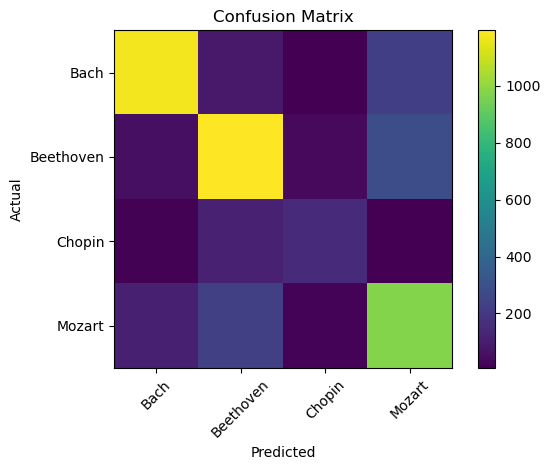

In [11]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
# Classification report
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_report.head()

,precision,recall,f1-score,support
Bach,0.860704,0.783189,0.820119,1499.000000
Beethoven,0.729383,0.756654,0.742768,1578.000000
Chopin,0.691964,0.506536,0.584906,306.000000
Mozart,0.648703,0.724907,0.684691,1345.000000
accuracy,0.739848,0.739848,0.739848,0.739848


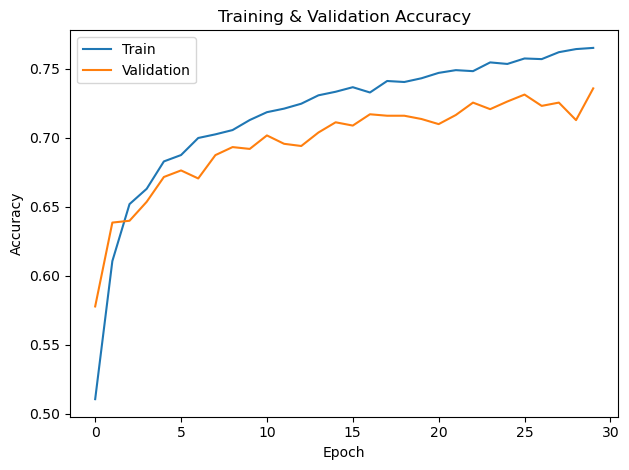

In [13]:
# Plot training history: accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

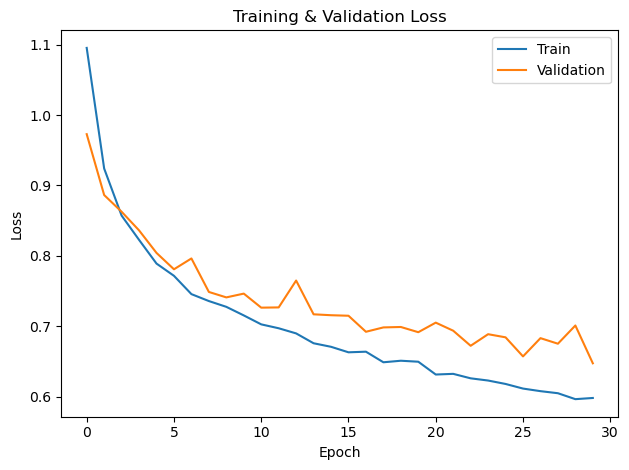

In [14]:
# Plot training history: loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()